In [1]:

import numpy as np

import ngsolve 
from ngsolve.webgui import Draw
import netgen.geom2d


### trying spiral chimera model 3 field reaction diffusion model

In [27]:
# https://docu.ngsolve.org/latest/i-tutorials/unit-4.1.2-csg2d/csg2d.html
geo = netgen.geom2d.CSG2d()

# make a circle with a hole in it!
circle1 = netgen.geom2d.Circle( center=(0,0), radius=1.0,  bc="outer" )
circle2 = netgen.geom2d.Circle( center=(0.1,0), radius=0.3,  bc="inner" )

annulus = circle1 - circle2
fac = 100
annulus.Scale(fac)   # recale system by fac !
geo.Add(annulus)

# generate the  mesh
maxh_mesh = 0.03*fac  # max distance between nodes?
mmesh = ngsolve.Mesh(geo.GenerateMesh(maxh=maxh_mesh))  # maxh here sets the scale of elements 
print(f"vertices={mmesh.nv}, edges ={mmesh.ne}")  # print numbers of vertices and edges!

Draw(mmesh) # show the mesh

vertices=3551, edges =6830


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

In [28]:
# create finite element system 'fes'  - we have two fields for the reaction diffusion equations 
korder = 3
Q1 = ngsolve.H1(mmesh, order=korder)   # Choose an element that is in the Sobolev space H1, first field
Q2 = ngsolve.H1(mmesh, order=korder)   # second field
Q3 = ngsolve.H1(mmesh, order=korder)   # third field
fes = Q1*Q2*Q3   # our finite element space is the product of the two spaces 
(u,v,w),(utt,vtt,wtt)  = fes.TnT()  # create test and trial functions  

gfu = ngsolve.GridFunction(fes) # to hold the solution 

# output fields 
u_out = gfu.components[0]
v_out = gfu.components[1]
w_out = gfu.components[1]

In [64]:
# create operators 
def mkops(fes,D_u,D_v,D_w,phi,a_p,b_p,c_p,epsilon_1,epsilon_2,dt):
    a = ngsolve.BilinearForm(fes)  # holds Laplacian operator for both fields 
    a += 1*D_u*ngsolve.grad(u)*ngsolve.grad(utt)*ngsolve.dx # This is laplacian with a diffusion coef on the first field
    a += 1*D_v*ngsolve.grad(v)*ngsolve.grad(vtt)*ngsolve.dx # 
    a += 1*D_w*ngsolve.grad(w)*ngsolve.grad(wtt)*ngsolve.dx # 
    a.Assemble()

    m = ngsolve.BilinearForm(fes)  # hold mass matrix for both fields 
    m += u*utt*ngsolve.dx + v*vtt*ngsolve.dx + w*wtt*ngsolve.dx
    m.Assemble()

    im = m.mat.CreateMatrix()
    invm = im.Inverse(freedofs=fes.FreeDofs())  # in case we want an inverse!

    reaction_lin =  ngsolve.BilinearForm(fes)
    Ru = (phi*a_p*u  - phi*b_p*v - phi*c_p*w)* utt  
    Rv = phi*epsilon_1*(u - v) * vtt
    Rw = phi*epsilon_2*(u - w) * wtt
    reaction_lin += Ru*ngsolve.dx + Rv*ngsolve.dx + Rw*ngsolve.dx
    reaction_lin.Assemble()

    #print(f"m.mat.nze = {m.mat.nze}, a1.mat.nze={a.mat.nze}") # check that they are the same
    # these are the number of nonzero elements in the sparse matrices

    # B = M - 0.5*L*dt , needed for Crank Nicholson update L = Laplacian times diffusion coeff, M = mass matrix
    b_op = m.mat.CreateMatrix()
    b_op.AsVector().data     = m.mat.AsVector() - 0.5*dt * ( a.mat.AsVector() - reaction_lin.mat.AsVector())
    #print(f"b.nze = {b_op.nze}")

    # A* = M + 0.5 * L * dt   needed for Crank Nicholson update 
    astar = m.mat.CreateMatrix() # create a matrix in the form of m
    astar.AsVector().data = m.mat.AsVector() + 0.5*dt * (a.mat.AsVector() - reaction_lin.mat.AsVector())
    invastar = astar.Inverse(freedofs=fes.FreeDofs())
    #print(f"astar.nze={astar.nze}")
    return invastar,b_op,invm


In [60]:
# arguments:
#  gfu :     # for holding solution, is a Gridfunction on a predefined mesh
#  invastar, b,invm :      # matrix operators on the finite element system 
#  nsamples:  number of outputs to store in the multidimensional data set 
#  rdtype: type of Reaction diffusion equation, is a string
#  alpha, beta: parameters for the reaction diffusion equation 
#  dt:        timestep  which is used in the matrix operators invastar and b 
#  reaction_by_hand:  how reactions are applied  (True/False)
# predefined things:
#  scene1 or and scene2  # for drawing fields, outputs of Draw ngsolve.webgui
# returns 
#  gfut:   a multidimensional set of grid functions on finite element system that holds time stepped results
# globals: 
#   test and trial functions u1,u2,v1,v2  if reaction_by_hand = False
#   Reaction() if reaction_by_hand = True
#reaction_by_hand=False  # now works!
def TimeStepping_CN(gfu, invastar, b_op, invm, \
                    phi,a_p,b_p,c_p,epsilon_1,epsilon_2,alpha, \
                    dt, initial_cond = None, t0 = 0, tend = 10, 
                    nsamples = 20,reaction_by_hand = True):
    if initial_cond:
        gfu.Set(initial_cond)   # set initial condition, otherwise don't touch the initial fields 
        # as the initial condition could be set already in gfu.vec.data
    cnt = 0; time = t0
    sample_int = int(np.floor(tend / dt / nsamples)+1)  # nsamples seems to be the number of outputs we want
    
    gfut = ngsolve.GridFunction(gfu.space,multidim=0)
    gfut.AddMultiDimComponent(gfu.vec)  #  so we can store a series of solutions 
    
    # create a nonlinear operator for the reactions
    if (reaction_by_hand==False):
        reaction =  ngsolve.BilinearForm(fes, nonassemble=True)
        Ru = - phi*alpha*u*u*u *utt  # nonlinear part alone 
        #Ru = (phi*a_p*u - phi*alpha*u*u*u - phi*b_p*v - phi*c_p*w)* utt  
        #Rv = phi*epsilon_1*(u - v) * vtt
        #Rw = phi*epsilon_2*(u - w) * wtt
        reaction += Ru*ngsolve.dx # + Rv*ngsolve.dx + Rw*ngsolve.dx

    while time < tend - 0.5 * dt:
        if (reaction_by_hand==False):
            reaction.Assemble()  # linearization is somehow done automatically here I think 
            
        res =  b_op * gfu.vec   # you can just multiply b onto gfu.vec (it is a matrix multiply!) # if b is just a matrix
        # res is defined here and is now a vector on the finite element system 
        gfu.vec.data = invastar * res  # replacing solution here for Crank Nicholson update  
        # note you can just multiply invastar onto res  (this is a matrix multiply!)

        if (reaction_by_hand==True):
            # operator split add in non-linear part by hand 
            upass = gfu.components[0].vec.FV().NumPy()[:]  # get the first field
            vpass = gfu.components[1].vec.FV().NumPy()[:]  # get the second field 
            wpass = gfu.components[1].vec.FV().NumPy()[:]  # get the second field 
            Ru,Rv,Rw = Reaction(upass,vpass,wpass,phi,a_p,b_p,c_p,epsilon_1,epsilon_2,alpha,)  # compute the nonlinear reactions 
            gfu.components[0].vec.FV().NumPy()[:] += dt*Ru
            gfu.components[1].vec.FV().NumPy()[:] += dt*Rv
            gfu.components[1].vec.FV().NumPy()[:] += dt*Rw
            # why I am doing this by hand?  NGsolve has non linear examples but I think they linearize and we want a fully 
            # non linear PDE here 
        else:
            res = reaction.mat*gfu.vec
            gfu.vec.data += dt*invm*res   
        
        print("\r",time,end="")
        scene1.Redraw()
        #scene2.Redraw()
        #if cnt % sample_int == 0:
        #    gfut.AddMultiDimComponent(gfu.vec)
        cnt += 1; time = cnt * dt
    return gfut

In [104]:
# create initial conditions!
# https://docu.ngsolve.org/latest/i-tutorials/unit-2.2-eigenvalues/pinvit.html 
# see this for how to do random initial conditions! 

#steady state for brusellator is u0 = alpha;  v0 = beta/alpha;  5.; 9.

# set initial conditions into gfu
# parameters:
#  gfu is output grid function
#  sig0: width of random uniform initial conditions 
#  u0, v0 constant offsets for initial conditions
# returns: nothing
def mkinit(gfu,sig0,nseeds):

    # output fields 
    u_out = gfu.components[0]
    v_out = gfu.components[1]
    w_out = gfu.components[2]

    #sig0 = 0.1; # width of uniform random distn 
    #mu0=sig0/2 # shift mean to this value 

    r1  = u1_out.vec.CreateVector()  # create vectors 
    r2  = u1_out.vec.CreateVector()
    r3  = u1_out.vec.CreateVector()

    r1.SetRandom(); # fill with random numbers 
    r2.SetRandom(); 
    r3.SetRandom(); 
    r1 = sig0*r1  # scale by sig0
    r2 = sig0*r2
    r3 = sig0*r3

    u_out.Set(0.0)  # set to  constn
    v_out.Set(0.0)  
    #w_out.Set(0.0) 

    ccf = 0.0  # will be a coefficient function 

    # seed with some 1 values 
    xxmin = -fac; xxmax = fac;  # max min ranges for domain, set by hand 
    yymin = -fac; yymax = fac;
    maxhval = maxh_mesh *5
    print(maxhval)
    for k in range(nseeds):
        x_p = np.random.uniform(xxmin,xxmax)  # random position
        y_p = np.random.uniform(yymin,yymax)
        rr2 = (ngsolve.x - x_p)*(ngsolve.x - x_p) + (ngsolve.y - y_p)*(ngsolve.y - y_p)
        ccf += ngsolve.exp(-0.5*rr2/maxhval**2)  # creates a coefficient function 
    ccf += 0.001*ngsolve.x
    w_out.Set(ccf) 

    #cclin = 0.01*ngsolve.x 
    v_out.Set(0.001*ngsolve.x - 0.001*ngsolve.y)
    u_out.Set(0.002*ngsolve.y+0.1)

    # add random stuff to initial fields 
    u_out.vec.data += r1   
    v_out.vec.data += r2 
    w_out.vec.data += r3 
    


In [105]:

D_u = 1.0e-2  #diffusion coefficients 
D_v = D_u
D_w  = 0.5 # (φ,b,c,ϵ1,α,Dw) = (0.62,3.0,3.5,1.0,4/3,0.5),
dt = 0.1    # timestep 
phi,b_p,c_p,epsilon_1,alpha = 0.62,3.0,3.5,1.0,4./3.
a_p = 3.8; epsilon_2 = 0.245

#phi,a_p,b_p,c_p,epsilon_1,epsilon_2,alpha

print(maxh_mesh**2/D_u,maxh_mesh**2/D_v,maxh_mesh**2/D_w )  # these should be larger than dt
# this is a CFL like condition for numerical stability
# CHECK that our dt is lower than these !!!!!!

# we define dt, D_u, D_v here because we need them to construct matrices 
# no boundary condition is yet specified which means we have a natural (zero Neumann) boundary condition 

# make the operators 
invastar,b_op,invm = mkops(fes,D_u,D_v,D_w,phi,a_p,b_p,c_p,epsilon_1,epsilon_2,dt)

900.0 900.0 18.0


In [106]:
gfu = ngsolve.GridFunction(fes)
u_out = gfu.components[0]
v_out = gfu.components[1]
w_out = gfu.components[2]
mkinit(gfu,0.02,4)  # make initial conditions and show them
scene1 = Draw(u_out,mmesh, settings = {  "Colormap" : { "ncolors" : 20 } });  # 
#scene2 = Draw(u2_out,mmesh)



15.0


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}},…

In [109]:
TimeStepping_CN(gfu, invastar, b_op, invm, \
                    phi,a_p,b_p,c_p,epsilon_1,epsilon_2,alpha, \
                    dt, initial_cond = None, t0 = 0, tend = 50, 
                    nsamples = 20,reaction_by_hand = False)

craete bilinearformapplication
 49.9000000000000064

In [32]:
# below if you want to display the fields by your self without a gui
# making a finer mesh
mmesh2 = ngsolve.Mesh(geo.GenerateMesh(maxh=maxh_mesh/2))  # maxh here sets the scale of elements 
print(f"vertices={mmesh.nv}, edges ={mmesh.ne}")  # print numbers of vertices and edges!

#Draw(mmesh2) # show the mesh

vertices=3551, edges =6830


In [33]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
%matplotlib inline

# get node points and triangles from a 2d ngsolve triangular mesh
def pts_tri(mesh):
    # find the x,y coordinates of the mesh 
    xv = np.zeros(mesh.nv)
    yv = np.zeros(mesh.nv)
    k=0 # store nodes 
    for v in mesh.vertices:
        #print(v,v.point)
        xv[k] = v.point[0]
        yv[k] = v.point[1]
        k+= 1
    # get a list of triangles in the mesh
    triangles = np.zeros((mesh.ne,3), dtype =int)  # number of elements
    k=0  # store triangles 
    for el in mesh.Elements():
        triangles[k,:] = np.array([el.vertices[0].nr, el.vertices[1].nr, el.vertices[2].nr], dtype = int)
        k += 1
    return xv,yv,triangles

xv,yv,triangles = pts_tri(mmesh2)
    
# let's see if we can write our own routine to display both fields 
# mesh need not be that associated with gfu as we use triangular interpolation 
# if you are running this over and over again (like to make pngs)
# then to make this more efficient you need to find the mesh points and triangles beforehand 
# in a separate routine 
def disp(mesh,gfu,t):
    fig,axarr = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True,dpi=150)
    plt.subplots_adjust(left=0.09,right=0.95,bottom=0.01,top=0.99)

    xv,yv,triangles = pts_tri(mesh) # get coordinates and triangles from the mesh
    
    # get the field values at all the vertices of the mesh
    # does interpolation, gfu need not be on the same mesh as the one passed here 
    uvals = np.zeros(mesh.nv)
    vvals = np.zeros(mesh.nv)
    for k in range(mesh.nv):
        uvals[k] = gfu.components[0](mesh(xv[k],yv[k]))
        vvals[k] = gfu.components[1](mesh(xv[k],yv[k]))

    ax0 = axarr[0]; ax1 = axarr[1]
    ax0.set_aspect('equal'); ax1.set_aspect('equal')

    ax0.tripcolor(xv, yv, uvals,  triangles=triangles)  # show field on triangles 
    ax1.tripcolor(xv, yv, vvals,  triangles=triangles)
    
    field0 = ax0.get_children()[0]  # vertex-based temperature-colour
    field1 = ax1.get_children()[0]  
    fig.colorbar(field0,shrink=0.7)  # colorbar!
    fig.colorbar(field1,shrink=0.7)
    title = ax0.set_title(f'u,    $t$ = {t:.3f}')  # time stamp
    title = ax1.set_title(f'v')
    plt.show()
    return fig,axarr

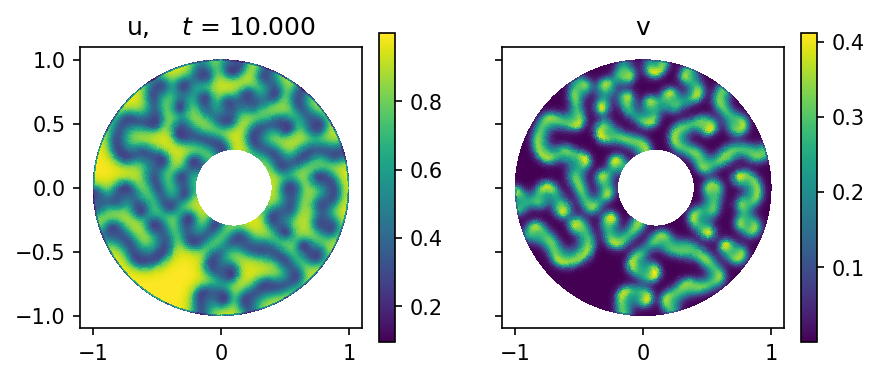

(<Figure size 900x450 with 4 Axes>,
 array([<Axes: title={'center': 'u,    $t$ = 10.000'}>,
        <Axes: title={'center': 'v'}>], dtype=object))

In [34]:
disp(mmesh2,gfu,10)  # worked but is not smooth and boundary does not look great
# still we could perhaps more easily make a movie this way by storing pngs than exporting vtks and using paraview